This notebook aims at testing supervised learning applied to bot detection on twitter

# Initialization

Imports.\
PySpark is used to manipulate dataframes.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sqlalchemy import create_engine
from sklearn.base import clone
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_curve, auc, classification_report, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier



PySpark session and link to access it.\
Do NOT forget to forward **port 4040** if using SSH.\
http://localhost:4040

In [4]:
dbname = 'tep2022'
user = 'petit'
password = 'MLK123aze999;'
host = 'localhost'
port = 5432

connection_string = f"postgresql+psycopg2://{user}:{password}@/{dbname}"
engine = create_engine(connection_string)

# All datasets

In [ ]:
users_cresci2017 = pd.read_sql('SELECT user_id, label, statuses_count, followers_count, friends_count, favourites_count, listed_count FROM cresci_2017_users', engine)
users_cresci2015 = pd.read_sql_query('SELECT user_id, label, statuses_count, followers_count, friends_count, favourites_count, listed_count FROM cresci_2015_users', engine)

### Cresci 2015

In [191]:
users_c15 = pd.read_sql_query('SELECT user_id, label, statuses_count, followers_count, friends_count, favourites_count, listed_count, created_at FROM cresci_2015_users', engine)
tweets_c15 = pd.read_sql_query('SELECT id, user_id, created_at, retweet_count, favorite_count, retweeted_status_id FROM cresci_2015_tweets', engine)
tweets_c15 = tweets_c15[tweets_c15.user_id.isin(users_c15.user_id)]

In [192]:
users_c15_c = users_c15.copy()

In [203]:
users_c15 = users_c15_c

In [204]:
# only select the user_id and retweeted_status_id columns
retweets_count = tweets_c15[['user_id', 'retweeted_status_id']]
retweets_count = retweets_count.groupby('user_id').count()
retweets_count = retweets_count.rename(columns={'retweeted_status_id': 'retweet_count'})
print(retweets_count.head())

            retweet_count
user_id                  
1000486495             18
1001305494           1064
1001875776            434
100219528               6
1002533372             52


In [205]:
# add age
users_c15 = users_c15.merge(retweets_count, on='user_id', how='left')
users_c15['created_at'] = pd.to_datetime(users_c15['created_at'])
users_c15['age'] = (pd.Timestamp.now() - users_c15['created_at']).dt.days
users_c15.drop(columns=['created_at'], inplace=True)
users_c15['favourites_count'] = pd.to_numeric(users_c15['favourites_count'], errors='coerce')
users_c15['statuses_count'] = pd.to_numeric(users_c15['statuses_count'], errors='coerce')
users_c15['fav_tweet_ratio'] = users_c15['favourites_count'] / users_c15['statuses_count']
users_c15['rt_tweet_ratio'] = users_c15['statuses_count'] / users_c15['retweet_count']
users_c15['tweet_frequency'] = users_c15['statuses_count'] / users_c15['age']

# column retweet_count by merging with retweets_count


users_c15.head()

,user_id,label,statuses_count,followers_count,friends_count,favourites_count,listed_count,retweet_count,age,fav_tweet_ratio,rt_tweet_ratio,tweet_frequency
0,24503,human,4340,5055,1466,267,256,3521.0,6652,0.061521,1.232604,0.652435
1,22903,human,164,132,194,12,4,160.0,6653,0.073171,1.025000,0.024651
2,382393,human,1070,1154,832,871,92,1036.0,6618,0.814019,1.032819,0.161680
3,286543,human,6892,930,535,478,28,3285.0,6622,0.069356,2.098021,1.040773
4,438023,human,2885,173,444,41,2,2880.0,6616,0.014211,1.001736,0.436064


### Twibot20

In [ ]:
users_tb20 = pd.read_sql_query('SELECT id, tweet_count, followers_count, following_count, listed_count, created_at FROM tb20_users', engine)\
    .rename(columns={'id': 'user_id', 'tweet_count': 'statuses_count', 'following_count': 'friends_count'})
rt_tb20 = pd.read_sql_query('SELECT * FROM tb20_user_retweet', engine)

labels_tb20 = pd.read_sql_query('SELECT * FROM tb20_label', engine)
users_tb20 = users_tb20.merge(labels_tb20, left_on='user_id', right_on='id').drop(columns=['id'])

In [109]:
# Feature engineering
users_tb20['created_at'] = pd.to_datetime(users_tb20['created_at'])
users_tb20['created_at'] = (pd.Timestamp.now() - users_tb20['created_at']).dt.days
users_tb20 = users_tb20.rename(columns={'created_at': 'age'})
users_tb20['follow_friend_ratio'] = users_tb20['followers_count'] / users_tb20['friends_count']
users_tb20 = users_tb20.merge(rt_tb20, left_on='user_id', right_on='user_id', how='left').fillna(0)
users_tb20['rt_tweet_ratio'] = users_tb20['retweet_count'] / users_tb20['statuses_count']
users_tb20['tweet_frequency'] = users_tb20['statuses_count'] / users_tb20['age']
users_tb20 = users_tb20.fillna(0)
users_tb20['favourite_count'] = 0
users_tb20['fav_tweet_ratio'] = 0
users_tb20['reply_count'] = 0
users_tb20 = users_tb20[['user_id', 'label', 'age', 'fav_tweet_ratio', 'listed_count', 'follow_friend_ratio', 'rt_tweet_ratio', 'reply_count', 'statuses_count', 'retweet_count', 'tweet_frequency']]

users_tb20.head()

,user_id,label,age,fav_tweet_ratio,listed_count,follow_friend_ratio,rt_tweet_ratio,reply_count,statuses_count,retweet_count,tweet_frequency
0,u17461978,human,5930,0,45568.0,22181.497110,0.003368,0,9798.0,33.0,1.652277
1,u1297437077403885568,bot,1634,0,0.0,0.000000,0.000000,0,0.0,0.0,0.000000
2,u17685258,human,5920,0,3201.0,1605.976842,0.023559,0,5518.0,130.0,0.932095
3,u15750898,human,6033,0,1744.0,68.233076,0.000394,0,192876.0,76.0,31.970164
4,u1659167666,bot,4204,0,44.0,20.593509,0.446602,0,103.0,46.0,0.024500


### Twibot22

In [ ]:
users_tb22 = pd.read_sql_query('SELECT id, tweet_count, followers_count, following_count, listed_count, created_at FROM tb22_user', engine)\
    .rename(columns={'id': 'user_id', 'tweet_count': 'statuses_count', 'following_count': 'friends_count'})
labels_tb22 = pd.read_sql_query('SELECT * FROM tb22_label', engine)
users_tb22 = users_tb22.merge(labels_tb22, left_on='user_id', right_on='id').drop(columns=['id'])

tweets_tb22 = pd.read_sql_query('SELECT id, author_id, retweet_count, like_count FROM tb22_tweet', engine)
tweets_tb22['author_id'] = 'u' + tweets_tb22['author_id'].astype(str)
retweets_tb22 = pd.read_sql_query('SELECT * FROM tb22_retweet', engine)
replies_tb22 = pd.read_sql_query('SELECT * FROM tb22_reply', engine)

In [ ]:
# Feature engineering
users_tb22 = users_tb22.merge(replies_tb22.groupby('source_id').sum('count').rename(columns={'count': 'reply_count'}), left_on='user_id', right_on='source_id', how='left')
users_tb22 = users_tb22.merge(retweets_tb22.groupby('source_id').sum('count').rename(columns={'count': 'retweet_count'}), left_on='user_id', right_on='source_id', how='left')
users_tb22['created_at'] = pd.to_datetime(users_tb22['created_at'])
users_tb22['created_at'] = (pd.Timestamp.now() - users_tb22['created_at']).dt.days
users_tb22.rename(columns={'created_at': 'age'}, inplace=True)
users_tb22['follow_friend_ratio'] = users_tb22['followers_count'] / users_tb22['friends_count']
users_tb22 = users_tb22.merge(tweets_tb22[['author_id', 'like_count']].groupby('author_id').sum('like_count').rename(columns={'like_count': 'fav_received'}), left_on='user_id', right_on='author_id', how='left')
users_tb22['fav_tweet_ratio'] = users_tb22['fav_received'] / users_tb22['statuses_count']
users_tb22['rt_tweet_ratio'] = users_tb22['retweet_count'] / users_tb22['statuses_count']
users_tb22['tweet_frequency'] = users_tb22['statuses_count'] / users_tb22['age']
users_tb22 = users_tb22[['user_id', 'label', 'age', 'fav_tweet_ratio', 'listed_count', 'follow_friend_ratio', 'rt_tweet_ratio', 'reply_count', 'statuses_count', 'retweet_count', 'tweet_frequency']]
users_tb22 = users_tb22.fillna(0)

users_tb22.head(3)

,user_id,label,age,fav_tweet_ratio,listed_count,follow_friend_ratio,rt_tweet_ratio,reply_count,statuses_count,retweet_count,tweet_frequency
0,u1217628182611927040,human,1854,5.975468,69,34.027907,0.074564,532.0,3098,231.0,1.670982
1,u2664730894,human,3877,0.131103,0,0.112844,0.182117,290.0,1823,332.0,0.470209
2,u1266703520205549568,human,1719,0.378788,0,0.048387,0.045455,28.0,66,3.0,0.038394


### Aditional info

In [ ]:
df_list = [users_cresci2017, users_cresci2015, users_tb20, users_tb22]
df_names = ['cresci2017', 'cresci2015', 'tb20', 'tb22']


# Model

In this cell, all the functions are defined

In [ ]:
# Object used to store the results of the prediction
class Report:
    def __init__(self, accuracy, precision, recall, specificity, f1, mcc, roc_auc):
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        self.specificity = specificity
        self.f1 = f1
        self.mcc = mcc
        self.roc_auc = roc_auc

    def __str__(self):
        return f"Accuracy: {self.accuracy:.4f}\nPrecision: {self.precision:.4f}\nRecall: {self.recall:.4f}\nSpecificity: {self.specificity:.4f}\nF1: {self.f1:.4f}\nMCC: {self.mcc:.4f}\nAUC: {self.roc_auc:.4f}"

    def __repr__(self):
        return f"Accuracy: {self.accuracy:.4f}\nPrecision: {self.precision:.4f}\nRecall: {self.recall:.4f}\nSpecificity: {self.specificity:.4f}\nF1: {self.f1:.4f}\nMCC: {self.mcc:.4f}\nAUC: {self.roc_auc:.4f}"

# Function to split the dataset into training and testing sets. If notest is set to True, the testing set is empty (for cross-validation)
def split(df, prop_bot, balancing=True, notest=False, testprop=0.2):
    df['label_num'] = np.where(df['label'] == 'bot', 1, 0)

    df_bot = df[df['label_num'] == 1]
    df_human = df[df['label_num'] == 0]

    if balancing:
        nb_bots = len(df_bot)
        nb_humans = len(df_human)

        sample_nb_humans = min(nb_bots / prop_bot, nb_humans)
        sample_nb_bots = sample_nb_humans * prop_bot
        
        if sample_nb_bots < 5:
            sample_nb_bots = 5
        if sample_nb_humans < 5:
            sample_nb_humans = 5
        
        df_bot = df_bot.sample(int(sample_nb_bots))
        df_human = df_human.sample(int(sample_nb_humans))

    df = pd.concat([df_bot, df_human])
    X = df[['statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count']]
    y = df['label_num']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testprop, stratify=y)

    if notest:
        X_train = X
        y_train = y
        X_test = []
        y_test = []

    return X_train, X_test, y_train, y_test  

# Function to split the dataset into training and testing sets
def split_test(df, prop_bot):
    df_bot = df[df['label_num'] == 1]
    df_human = df[df['label_num'] == 0]

    nb_bots = len(df_human) * prop_bot
    df_bot = df_bot.sample(int(nb_bots))

# Function to train the model, using grid search if specified
def train(X_train, y_train, using_grid_search=True):
    if not using_grid_search:
        rf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True)
        rf.fit(X_train, y_train)
        # scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='matthews_corrcoef')
        return rf
    
    rf = RandomForestClassifier()
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 50, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 4],
        'bootstrap': [True]
    }
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0) # CROSS VALIDATION 5 FOLDS 
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

# Function to train the model using cross-validation with 5 folds
def train_cv(X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True)
    
    reports = []

    for train_index, test_index in cv.split(X, y):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        clf = clone(model)
        clf.fit(X_train_cv, y_train_cv)

        y_pred = clf.predict(X_test_cv)
        y_prob = clf.predict_proba(X_test_cv)[:, 1]

        acc = accuracy_score(y_test_cv, y_pred)
        prec = precision_score(y_test_cv, y_pred)
        rec = recall_score(y_test_cv, y_pred)
        spec = recall_score(y_test_cv, y_pred, pos_label=0)
        f1 = f1_score(y_test_cv, y_pred)
        mcc = matthews_corrcoef(y_test_cv, y_pred)
        roc_auc = roc_auc_score(y_test_cv, y_prob)
        
        # create a report object
        report = Report(acc, prec, rec, spec, f1, mcc, roc_auc)
        reports.append(report)

    return reports

# Function to evaluate the model using various metrics
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1] 

    cm = confusion_matrix(y_test, y_pred)
    tp, fp, fn, tn = cm.ravel()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_scores)

    return Report(accuracy, precision, recall, specificity, f1, mcc, roc_auc)

# Function running a series of tests and returning the results
def run_test(df, prop_bot, repetitions, using_fav_count=True, using_grid_search=False, balancing=True):
    reports = []
    for _ in range(repetitions):
        X_train, X_test, y_train, y_test = split(df, prop_bot, using_fav_count, balancing)
        model = train(X_train, y_train, using_grid_search)
        report = evaluate(model, X_test, y_test)
        reports.append(report)
    return reports

# Function running a series of tests using cross-validation and returning the results
def run_test_cv(df, prop_bot, balancing=True):
    X_train, X_test, y_train, y_test = split(df, prop_bot, balancing, notest=True)
    reports = train_cv(X_train, y_train)
    return reports

# Function running a series of tests on a training set and a different testing set and returning the results
def run_on_other(df_train, df_test, prop_bot, repetitions, using_fav_count=True, using_grid_search=False, balancing=True):
    reports = []
    for _ in range(repetitions):
        X_train, _, y_train, _ = split(df_train, prop_bot, using_fav_count, balancing, notest=True)
        X_test, _, y_test, _ = split(df_test, prop_bot, using_fav_count, balancing, notest=True)
        model = train(X_train, y_train, using_grid_search)
        report = evaluate(model, X_test, y_test)
        reports.append(report)
    return reports

# Function to print the average and standard deviation of each metric
def print_avg_std(reports):
    accuracy = np.mean([r.accuracy for r in reports])
    precision = np.mean([r.precision for r in reports])
    recall = np.mean([r.recall for r in reports])
    specificity = np.mean([r.specificity for r in reports])
    f1 = np.mean([r.f1 for r in reports])
    mcc = np.mean([r.mcc for r in reports])
    roc_auc = np.mean([r.roc_auc for r in reports])

    accuracy_std = np.std([r.accuracy for r in reports])
    precision_std = np.std([r.precision for r in reports])
    recall_std = np.std([r.recall for r in reports])
    specificity_std = np.std([r.specificity for r in reports])
    f1_std = np.std([r.f1 for r in reports])
    mcc_std = np.std([r.mcc for r in reports])
    roc_auc_std = np.std([r.roc_auc for r in reports])

    print("Accuracy:", accuracy, "+-", accuracy_std)
    print("Precision:", precision, "+-", precision_std)
    print("Recall:", recall, "+-", recall_std)
    print("Specificity:", specificity, "+-", specificity_std)
    print("F1:", f1, "+-", f1_std)
    print("MCC:", mcc, "+-", mcc_std)
    print("ROC AUC:", roc_auc, "+-", roc_auc_std)


# TRAINING and TESTING on the same dataset

### Framework

Function calculating all the metrics over 3 series, average and std. 

Places the results in a CSV under the results/abreu/ directory on top of printing them

In [14]:
def run_tests(prop_bot, filename, balancing=True):
    os.makedirs('./results/abreu', exist_ok=True)

    results = []

    for df, name in tqdm(zip(df_list, df_names), total=len(df_list)):
        reports = run_test_cv(df, prop_bot, balancing=balancing)
        accuracy = np.mean([r.accuracy for r in reports])
        precision = np.mean([r.precision for r in reports])
        recall = np.mean([r.recall for r in reports])
        specificity = np.mean([r.specificity for r in reports])
        f1 = np.mean([r.f1 for r in reports])
        mcc = np.mean([r.mcc for r in reports])
        roc_auc = np.mean([r.roc_auc for r in reports])

        accuracy_std = np.std([r.accuracy for r in reports])
        precision_std = np.std([r.precision for r in reports])
        recall_std = np.std([r.recall for r in reports])
        specificity_std = np.std([r.specificity for r in reports])
        f1_std = np.std([r.f1 for r in reports])
        mcc_std = np.std([r.mcc for r in reports])
        roc_auc_std = np.std([r.roc_auc for r in reports])

        results.append([name, accuracy, accuracy_std, precision, precision_std, recall, recall_std, specificity, specificity_std, f1, f1_std, mcc, mcc_std, roc_auc, roc_auc_std])

    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results, columns=['dataset', 'accuracy', 'accuracy_std', 'precision', 'precision_std', 'recall', 'recall_std', 'specificity', 'specificity_std', 'f1', 'f1_std', 'mcc', 'mcc_std', 'roc_auc', 'roc_auc_std'])
    results_df.to_csv(f'./results/abreu/{filename}.csv', index=False)
    return results_df
    

### Sample statistics

Since each dataset is sampled so as to obtain the required bot/human ratio, this cell shows the size of each sample, for each dataset and bot/human prop.

In [16]:
def show_dataset_stats():
    prop_bots = [1, 1/4, 1/9, 1/19]
    
    for prop_bot in prop_bots:
        results = []
        for df, name in zip(df_list, df_names):
            df_bot = df[df['label'] == 'bot']
            df_human = df[df['label'] == 'human']

            nb_bots = len(df_bot)
            nb_humans = len(df_human)

            sample_nb_humans = min(nb_bots / prop_bot, nb_humans)
            sample_nb_bots = sample_nb_humans * prop_bot

            results.append([name, nb_bots, nb_humans, sample_nb_bots, sample_nb_humans])

        print(f"############### prop_bot: {prop_bot}")
        results_df = pd.DataFrame(results, columns=['dataset', 'nb_bots', 'nb_humans', 'sampled_nb_bots', 'sampled_nb_humans'])
        print(results_df)

show_dataset_stats()

############### prop_bot: 1
             dataset  nb_bots  nb_humans  sampled_nb_bots  sampled_nb_humans
0         cresci2017     8263       3474           3474.0             3474.0
1         cresci2015     3349       1952           1952.0             1952.0
2             gilani     1090       1413           1090.0             1090.0
3       crescirtbust      353        340            340.0              340.0
4            midterm    42446       8092           8092.0             8092.0
5  botometerfeedback      139        380            139.0              139.0
6               tb20     6589       5237           5237.0             5237.0
7               tb22   139943     860057         139943.0           139943.0
############### prop_bot: 0.25
             dataset  nb_bots  nb_humans  sampled_nb_bots  sampled_nb_humans
0         cresci2017     8263       3474           868.50             3474.0
1         cresci2015     3349       1952           488.00             1952.0
2             gil

### sandbox

In [39]:
# tester train_cv avec cresci 2017
X_train, X_test, y_train, y_test = split(users_cresci2017, 1, using_fav_count=False, balancing=True)
reports = train_cv(X_train, y_train)

In [42]:
print(reports[2])

Accuracy: 0.9640
Precision: 0.9778
Recall: 0.9496
Specificity: 0.9784
F1: 0.9635
MCC: 0.9284
AUC: 0.9930


### 50/50

3 repetitions, average and std for all datasets without favourite count column

Balanced dataset (bots:humans = 1:1)

In [11]:
balanced = run_tests(1, '50', True)
print(balanced)

100%|██████████| 8/8 [03:35<00:00, 26.99s/it]

             dataset  accuracy  accuracy_std  precision  precision_std  \
0         cresci2017  0.984457      0.003168   0.988134       0.004227   
1         cresci2015  0.982324      0.004251   0.987607       0.005929   
2             gilani  0.744954      0.010797   0.763005       0.017433   
3       crescirtbust  0.775000      0.023985   0.774591       0.022266   
4            midterm  0.948777      0.002483   0.945244       0.004752   
5  botometerfeedback  0.741299      0.052511   0.758916       0.074781   
6               tb20  0.725129      0.008161   0.689533       0.008930   
7               tb22  0.747101      0.002151   0.729791       0.001863   

     recall  recall_std  specificity  specificity_std        f1    f1_std  \
0  0.980716    0.005865     0.988199         0.004305  0.984395  0.003202   
1  0.976943    0.005857     0.987699         0.005943  0.982229  0.004270   
2  0.711927    0.028038     0.777982         0.027308  0.736047  0.013523   
3  0.776471    0.045943  

### 20/80

3 repetitions, average and std for all datasets without favourite count column

Unbalanced dataset (bots:humans = 1:4 = 20%/80%)

In [17]:
unbalanced20 = run_tests(1/4, '20', True)
print(unbalanced20)

100%|██████████| 8/8 [09:32<00:00, 71.61s/it] 

             dataset  accuracy  accuracy_std  precision  precision_std  \
0         cresci2017  0.989176      0.002479   0.972430       0.007429   
1         cresci2015  0.986066      0.003974   0.975077       0.012281   
2             gilani  0.848828      0.021252   0.700773       0.094215   
3       crescirtbust  0.825882      0.029199   0.634019       0.153896   
4            midterm  0.958675      0.002824   0.918708       0.015352   
5  botometerfeedback  0.835789      0.019523   0.718250       0.180983   
6               tb20  0.788115      0.006052   0.439222       0.032081   
7               tb22  0.804986      0.000356   0.524833       0.001793   

     recall  recall_std  specificity  specificity_std        f1    f1_std  \
0  0.973503    0.009386     0.993092         0.001907  0.972933  0.006238   
1  0.954934    0.017778     0.993853         0.003071  0.964762  0.010175   
2  0.424990    0.075352     0.954723         0.015045  0.526800  0.081268   
3  0.294118    0.111610  

### 10/90

In [ ]:
unbalanced10 = run_tests(1/9, '10', True)
print(unbalanced10)

 38%|███▊      | 3/8 [00:03<00:06,  1.22s/it]/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 88%|████████▊ | 7/8 [00:11<00:02,  2.03s/it]

### 5/95

In [ ]:
unbalanced5 = run_tests(1/19, '5', True)
print(unbalanced5)

NameError: name 'run_tests' is not defined

### 1/99

In [ ]:
unbalanced1 = run_tests(1/99, '1', True)
print(unbalanced1)

NameError: name 'run_tests' is not defined

### No Balancing

In [ ]:
results = run_tests(1, 'nobal', False)
print(results)

NameError: name 'run_tests' is not defined

# Generalization

For each dataset, a model is trained on it, and tested on the rest

### Layout

In [ ]:
def train_test_on_all(bot_prop, filename, legend, balancing=True):

    # TRAIN ON ALL, TEST ON ALL

    df_results = pd.DataFrame(index=df_names, columns=df_names)

    for train_df, train_name in zip(df_list, df_names):
        X_train, _, y_train, _ = split(train_df, bot_prop, using_fav_count=False, balancing=True, notest=True)
        model = train(X_train, y_train, False)

        for test_df, test_name in zip(df_list, df_names):
            X_test, _, y_test, _ = split(test_df, 1, using_fav_count=False, balancing=True, notest=True)
            report = evaluate(model, X_test, y_test)
            df_results.loc[train_name, test_name] = report.mcc

    # to normalize MCC, we add 1 first to avoid negative values
    #df_results_normalized = df_results.add(1)
    #df_results_normalized = df_results.div(df_results.max(axis=1), axis=0)
    #df_results_normalized = df_results_normalized.apply(pd.to_numeric)
    df_results_normalized = df_results.apply(pd.to_numeric)


    # PLOT

    plt.figure(figsize=(10, 8))
    sns.heatmap(df_results_normalized, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'MCC'}, annot_kws={'size': 18}, vmin=-1, vmax=1)
    plt.title(legend)
    plt.xlabel("Test Datasets")
    plt.ylabel("Train Datasets")
    plt.tight_layout()
    plt.show()


    # SAVE TO CSV

    df_results.to_csv(f'./results/abreu/{filename}.csv', index=True)

### Balanced (50/50)

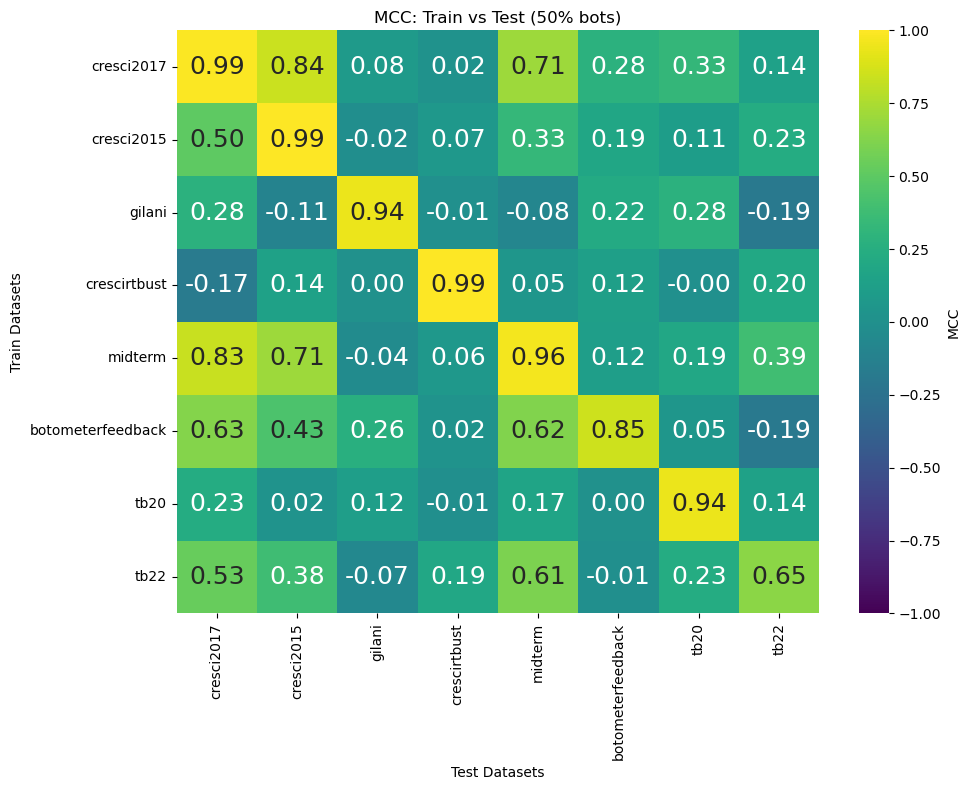

In [110]:
train_test_on_all(1, 'train_test_50', "MCC: Train vs Test (50% bots)", True)

### 20/80

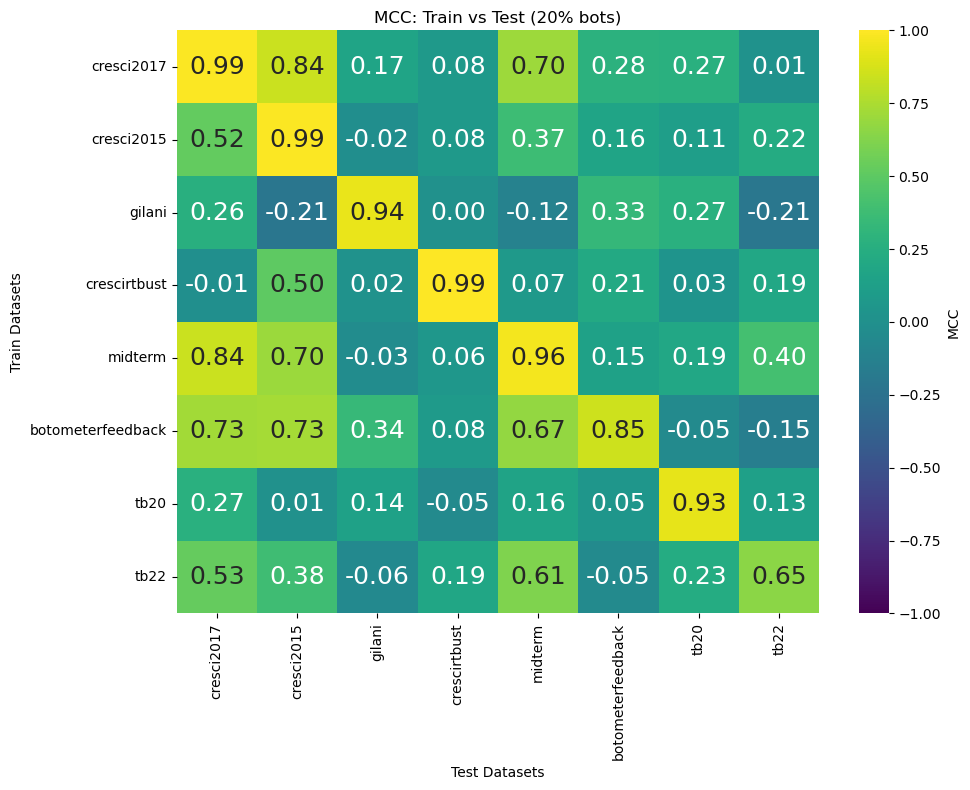

In [116]:
train_test_on_all(1/4, 'train_test_20', "MCC: Train vs Test (20% bots)", True)

### 10/90

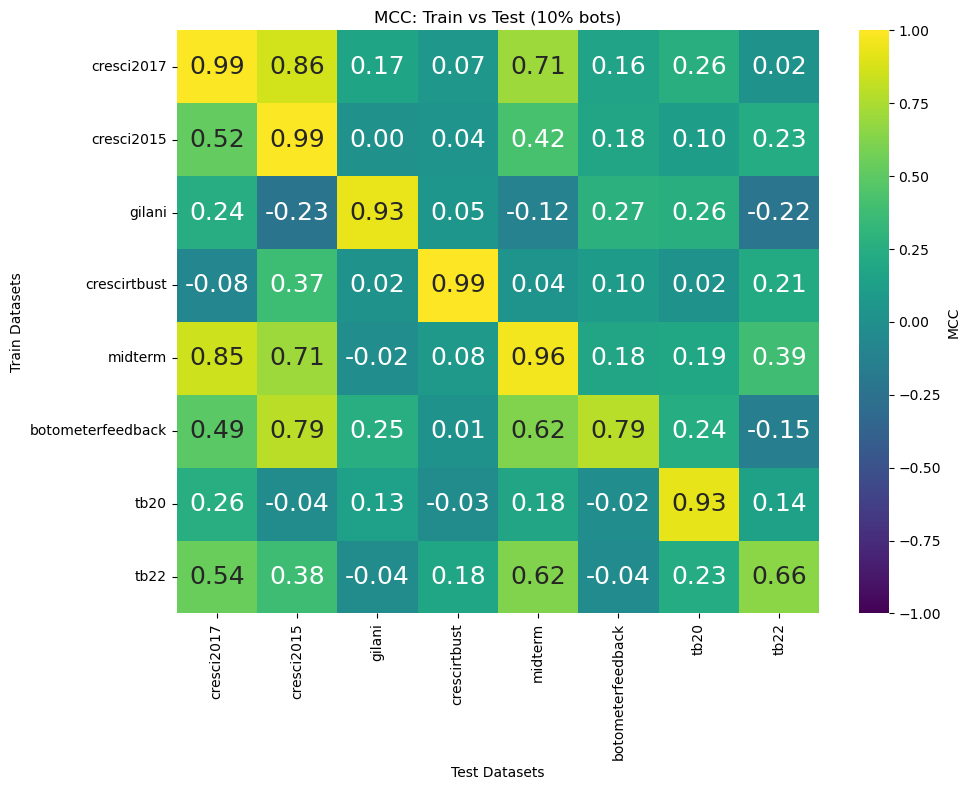

In [112]:
train_test_on_all(1/9, 'train_test_10', "MCC: Train vs Test (10% bots)", True)

### 5/95

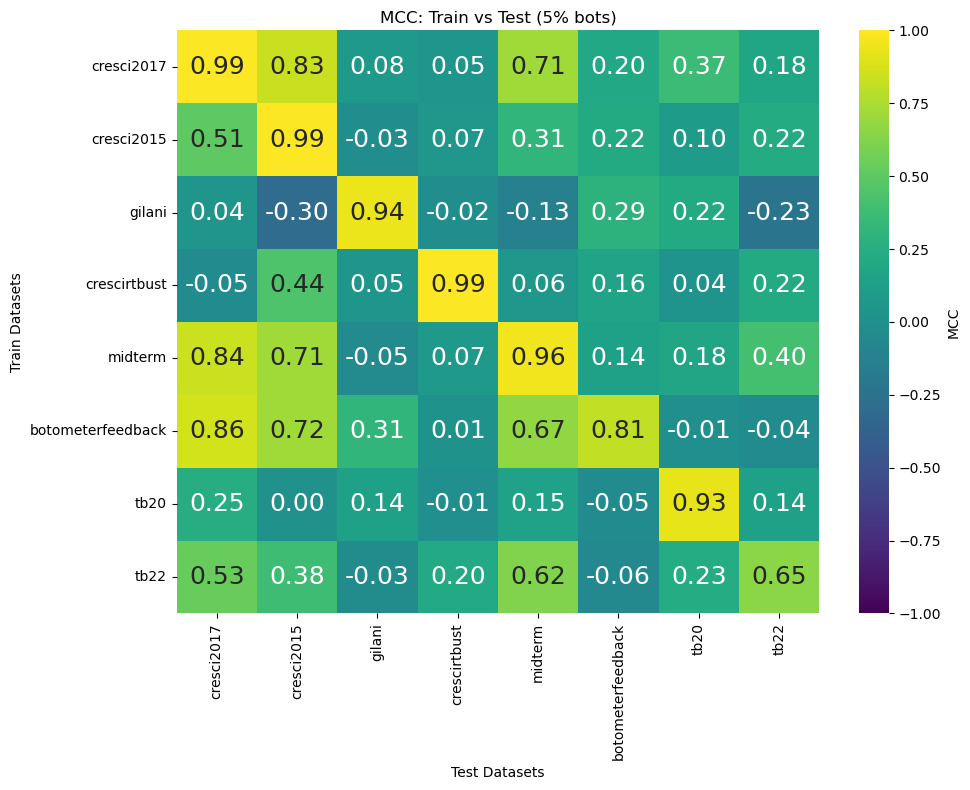

In [113]:
train_test_on_all(1/19, 'train_test_5', "MCC: Train vs Test (5% bots)", True)

### 1/99

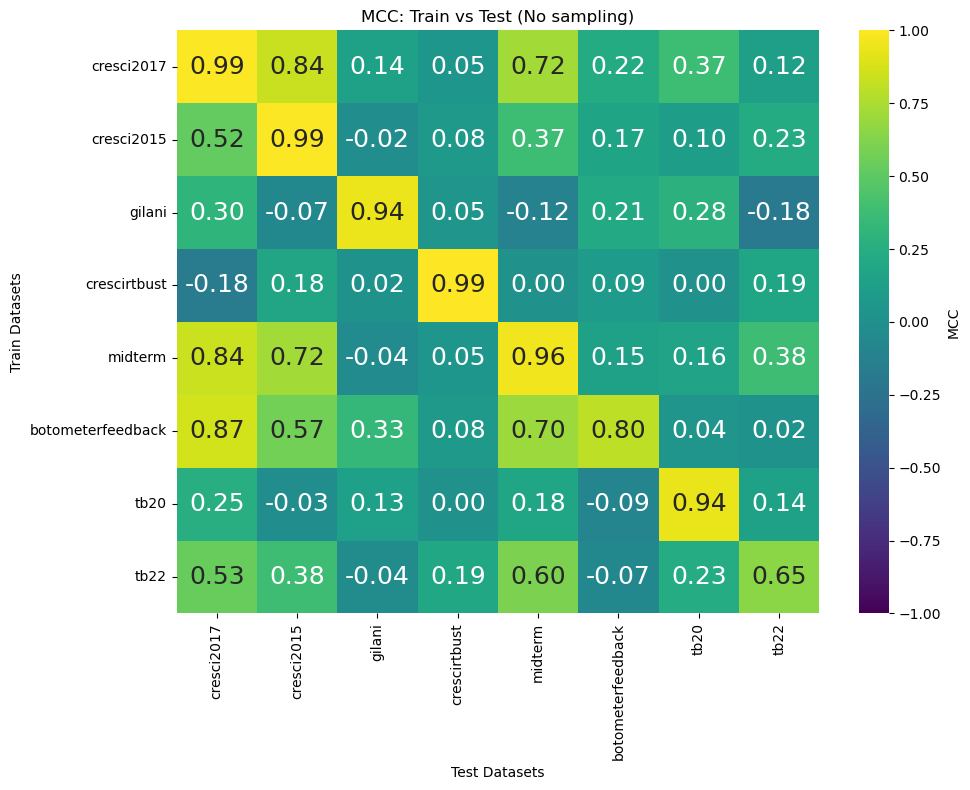

In [ ]:
train_test_on_all(1/99, 'train_test_1', "MCC: Train vs Test (1% bots)", False)

### No balancing

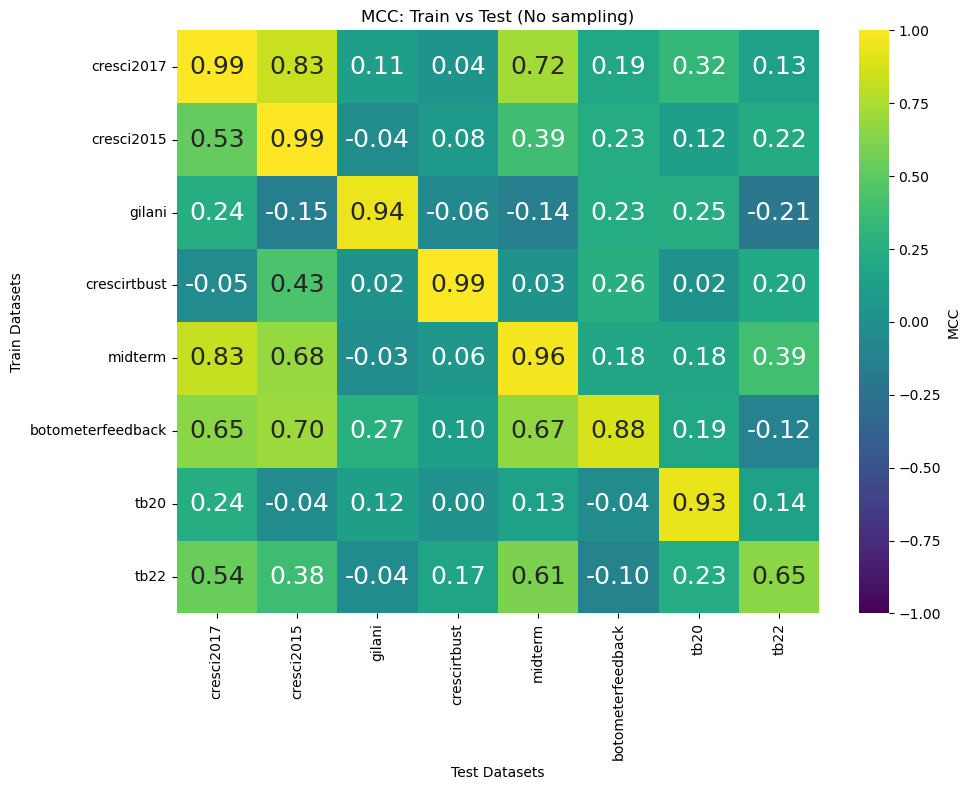

In [115]:
train_test_on_all(1, 'train_test_on_all_nobalancing', "MCC: Train vs Test (No sampling)", False)